In [45]:
# read sentiment score from txt
path = "../data/Data_Set_S1.txt"
with open(path, 'r') as f:
    sentiment_score = f.read().strip()
print(f"Sentiment score: {sentiment_score}")

Sentiment score: labMIT-1.0.txt
language assessment by Mechanical Turk 1.0

word	happiness_rank	happiness_average	happiness_standard_deviation	twitter_rank	google_rank	nyt_rank	lyrics_rank
laughter	1	8.50	0.9313	3600	--	--	1728
happiness	2	8.44	0.9723	1853	2458	--	1230
love	3	8.42	1.1082	25	317	328	23
happy	4	8.30	0.9949	65	1372	1313	375
laughed	5	8.26	1.1572	3334	3542	--	2332
laugh	6	8.22	1.3746	1002	3998	4488	647
laughing	7	8.20	1.1066	1579	--	--	1122
excellent	8	8.18	1.1008	1496	1756	3155	--
laughs	9	8.18	1.1551	3554	--	--	2856
joy	10	8.16	1.0568	988	2336	2723	809
successful	11	8.16	1.0759	2176	1198	1565	--
win	12	8.12	1.0812	154	3031	776	694
rainbow	13	8.10	0.9949	2726	--	--	1723
smile	14	8.10	1.0152	925	2666	2898	349
won	15	8.10	1.2164	810	1167	439	1493
pleasure	16	8.08	0.9655	1497	1526	4253	1398
smiled	17	8.08	1.0660	--	3537	--	2248
rainbows	18	8.06	1.3603	--	--	--	4216
winning	19	8.04	1.0490	1876	--	1426	3646
celebration	20	8.02	1.5318	3306	--	2762	4070
enjoyed	21	8.02	1.5318	15

In [46]:
import os
import io
import numpy as np
import requests
import pandas as pd
# Fetch sentimantal scores from dataset
local_sentiment_data = "data/Data_Set_S1.txt"
raw_sentiment_url = f"https://raw.githubusercontent.com/rifolio/dtu-projects-2025-autumn/master/social-graphs/{local_sentiment_data}"

if os.path.exists(local_sentiment_data):
    df = pd.read_csv(local_sentiment_data, sep="\t", skiprows=2, header=0)
else:
    r = requests.get(raw_sentiment_url, timeout=30)
    r.raise_for_status()
    with io.StringIO(r.text) as fh:
        df = pd.read_csv(fh, sep="\t", skiprows=2, header=0)

df["word"] = df["word"].astype("string")
for col in ["twitter_rank", "google_rank", "nyt_rank", "lyrics_rank"]:
    df[col] = df[col].replace("--", np.nan)
    df[col] = pd.to_numeric(df[col], errors="coerce").astype("Int64")
    
df.head()

,word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank
0,laughter,1,8.50,0.9313,3600,<NA>,<NA>,1728
1,happiness,2,8.44,0.9723,1853,2458,<NA>,1230
2,love,3,8.42,1.1082,25,317,328,23
3,happy,4,8.30,0.9949,65,1372,1313,375
4,laughed,5,8.26,1.1572,3334,3542,<NA>,2332


In [47]:
word_to_happiness_avg = dict(zip(df["word"], df["happiness_average"]))

def sentiment_score(text: str):
    tokens_lower = text.lower().split()
    scores = [
        word_to_happiness_avg[token] for token in tokens_lower if token in word_to_happiness_avg
    ]
    if scores:
        return sum(scores) / len(scores)
    return None

print("Sentiment dataset statistics:")
print(f"Total words with sentiment scores: {len(word_to_happiness_avg)}")
print(f"Dataset min sentiment score: {min(word_to_happiness_avg.values())}")
print(f"Dataset max sentiment score: {max(word_to_happiness_avg.values())}")
print(f"Dataset mean sentiment score: {np.mean(list(word_to_happiness_avg.values())):.4f}")
print(f"Dataset percentiles (25%, Median, 75%):", np.percentile(list(word_to_happiness_avg.values()), [25, 50, 75]))

Sentiment dataset statistics:
Total words with sentiment scores: 10222
Dataset min sentiment score: 1.3
Dataset max sentiment score: 8.5
Dataset mean sentiment score: 5.3752
Dataset percentiles (25%, Median, 75%): [4.9  5.44 6.02]


In [48]:
from bs4 import BeautifulSoup
import re
import json
from collections import defaultdict
from pathlib import Path

# Set up data directory
DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

In [49]:
# Setup scripts dictionary
scripts = {}
for movie in ["A New Hope", "The Empire Strikes Back", "Return of the Jedi"]:
    script_file = DATA_DIR / f"html/Star-Wars-{movie.replace(' ', '-')}.html"
    with open(script_file, "r", encoding="utf-8", errors="replace") as f:
        scripts[movie] = f.read()

In [50]:
from nltk.corpus import stopwords
import nltk

# Download stopwords if not already present
try:
    stop_words = set(stopwords.words('english'))
except:
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))


def fetch_script_from_file(file_path):
    """Load a Star Wars script from local HTML file"""
    print(f"Loading: {file_path}")
    with open(file_path, "r", encoding="utf-8", errors="replace") as f:
        return f.read()


def extract_scenes_and_characters(html_content):
    """Extract scene headings and character names from script HTML"""
    soup = BeautifulSoup(html_content, "html.parser")
    
    # Find the table with class="scrtext" which marks the start of the actual script
    script_table = soup.find("td", class_="scrtext")
    if not script_table:
        print("Warning: Could not find scrtext table in HTML")
        return [], {}, {}
    
    # Find the pre tag within the script table
    pre_tag = script_table.find("pre")
    if not pre_tag:
        print("Warning: Could not find pre tag in script table")
        return [], {}, {}
    
    script_text = pre_tag.get_text()
    lines = script_text.split("\n")
    
    scenes = []
    # Track all dialogue per location and character
    location_dialogues = {}  # location -> list of dialogue lines
    character_dialogues = {}  # character -> list of dialogue lines
    
    current_scene = {"location": None, "characters": set(), "content": []}
    current_location = None
    scene_started = False  # Track if we've reached the actual script content
    
    for line in lines:
        line_stripped = line.strip()
        
        # Detect scene headings
        # Format 1: "INT. LOCATION" or "EXT. LOCATION"
        # Format 2 (Return of the Jedi): "1    INT LOCATION" or "3    EXT LOCATION"
        # Format 3 (Return of the Jedi special): "1    SPACE" or "19   HOLDING TUNNEL"
        is_scene_heading = False
        
        # Check for numbered scene format (any line starting with number + spaces + capital letter)
        # This catches both "3    INT DEATH STAR" and "1    SPACE"
        if re.match(r"^[0-9]+\s+[A-Z]", line_stripped):
            is_scene_heading = True
            scene_started = True
        # Check for standard format (e.g., "INT. DEATH STAR")
        elif re.match(r"^(INT|EXT)\.\s+", line_stripped):
            is_scene_heading = True
            scene_started = True
        
        if is_scene_heading:
            # Save previous scene if it has a location (even with 0 characters)
            if current_scene["location"] is not None:
                scenes.append(current_scene)
            
            current_location = line_stripped
            current_scene = {
                "location": current_location,
                "characters": set(),
                "content": [],
            }
            
            # Initialize location dialogue list if new
            if current_location not in location_dialogues:
                location_dialogues[current_location] = []
        
        # Only process character names after we've started seeing actual scenes
        elif (
            scene_started
            and re.match(r"^[A-Z][A-Z\s\-\']*$", line_stripped)
            and len(line_stripped) > 1
            and len(line_stripped) < 50
        ):
            # This is likely a character name
            char_name = line_stripped.strip()
            # Filter out common non-character all-caps text
            if char_name and char_name not in [
                "FADE IN:",
                "FADE OUT:",
                "THE END",
                "CREDITS",
                "TO BE CONTINUED",
                "CUT TO:",
                "DISSOLVE TO:",
                "CONTINUED:",
            ]:
                current_scene["characters"].add(char_name)
                current_scene["content"].append(("CHARACTER", char_name))
                
                # Initialize character dialogue list if new
                if char_name not in character_dialogues:
                    character_dialogues[char_name] = []
        
        else:
            if line_stripped and scene_started:
                current_scene["content"].append(("DIALOGUE", line_stripped))
                
                # Add dialogue to current location
                if current_location:
                    location_dialogues[current_location].append(line_stripped)
                
                # Add dialogue to all characters in current scene
                for char in current_scene["characters"]:
                    character_dialogues[char].append(line_stripped)
    
    # Don't forget the last scene
    if current_scene["location"] is not None:
        scenes.append(current_scene)
    
    # Calculate sentiment scores for locations (with stop words removed)
    location_sentiments = {}
    for location, dialogues in location_dialogues.items():
        combined_text = " ".join(dialogues)
        sentiment = sentiment_score(combined_text)
        location_sentiments[location] = sentiment
    
    # Calculate sentiment scores for characters (with stop words removed)
    character_sentiments = {}
    for character, dialogues in character_dialogues.items():
        combined_text = " ".join(dialogues)
        sentiment = sentiment_score(combined_text)
        character_sentiments[character] = sentiment
    
    return scenes, location_sentiments, character_sentiments

# Load all three scripts from local files
scripts = {}
scripts["A New Hope"] = fetch_script_from_file(
    DATA_DIR / "html" / "Star-Wars-A-New-Hope.html"
)
scripts["The Empire Strikes Back"] = fetch_script_from_file(
    DATA_DIR / "html" / "Star-Wars-The-Empire-Strikes-Back.html"
)
scripts["Return of the Jedi"] = fetch_script_from_file(
    DATA_DIR / "html" / "Star-Wars-Return-of-the-Jedi.html"
)

print("Scripts loaded successfully!")

# Extract scenes from each script
all_scenes = {}
all_location_sentiments_by_movie = {}
all_character_sentiments_by_movie = {}

# Track character connections and location-character relationships
character_connections = {}  # character -> {other_character: count}
location_characters = {}  # location -> set of characters

for title, html in scripts.items():
    print(f"\nParsing {title}...")
    scenes, location_sentiments, character_sentiments = extract_scenes_and_characters(html)
    
    all_scenes[title] = scenes
    all_location_sentiments_by_movie[title] = location_sentiments
    all_character_sentiments_by_movie[title] = character_sentiments
    
    # Build character connections from scenes
    for scene in scenes:
        characters = list(scene["characters"])
        location = scene["location"]
        
        # Track which characters appear in each location
        if location:
            if location not in location_characters:
                location_characters[location] = set()
            location_characters[location].update(characters)
        
        # Track character co-appearances
        for i, char1 in enumerate(characters):
            if char1 not in character_connections:
                character_connections[char1] = {}
            
            for char2 in characters[i+1:]:
                # Add bidirectional connections
                character_connections[char1][char2] = character_connections[char1].get(char2, 0) + 1
                
                if char2 not in character_connections:
                    character_connections[char2] = {}
                character_connections[char2][char1] = character_connections[char2].get(char1, 0) + 1
    
    print(f"  Found {len(scenes)} scenes with character interactions")
    print(f"  Analyzed {len(location_sentiments)} unique locations")
    print(f"  Analyzed {len(character_sentiments)} unique characters")
    
    # Show sample
    if scenes:
        sample = scenes[0]
        print(f"  Sample scene: {sample['location']}")
        print(f"  Characters: {sample['characters']}")
    
    # Show top sentiment locations and characters
    if location_sentiments:
        sorted_locations = sorted(location_sentiments.items(), key=lambda x: x[1] if x[1] else 0, reverse=True)
        if sorted_locations and sorted_locations[0][1] is not None:
            print(f"  Happiest location: {sorted_locations[0][0][:50]}... (score: {sorted_locations[0][1]:.3f})")
    
    if character_sentiments:
        sorted_characters = sorted(character_sentiments.items(), key=lambda x: x[1] if x[1] else 0, reverse=True)
        if sorted_characters and sorted_characters[0][1] is not None:
            print(f"  Happiest character: {sorted_characters[0][0]} (score: {sorted_characters[0][1]:.3f})")

# Merge sentiments from all movies
all_character_sentiments = {}
all_location_sentiments = {}

for title in scripts.keys():
    all_character_sentiments.update(all_character_sentiments_by_movie[title])
    all_location_sentiments.update(all_location_sentiments_by_movie[title])

print(f"\n\nTotal unique characters: {len(character_connections)}")
print(f"Total unique locations: {len(location_characters)}")

Loading: data/html/Star-Wars-A-New-Hope.html
Loading: data/html/Star-Wars-The-Empire-Strikes-Back.html
Loading: data/html/Star-Wars-Return-of-the-Jedi.html
Scripts loaded successfully!

Parsing A New Hope...
  Found 479 scenes with character interactions
  Analyzed 169 unique locations
  Analyzed 73 unique characters
  Sample scene: INT. REBEL BLOCKADE RUNNER - MAIN PASSAGEWAY
  Characters: {'THREEPIO'}
  Happiest location: INT. GOLD LEADER'S COCKPIT... (score: 5.855)
  Happiest character: TROOPER VOICE (score: 5.913)

Parsing The Empire Strikes Back...
  Found 277 scenes with character interactions
  Analyzed 154 unique locations
  Analyzed 52 unique characters
  Sample scene: EXT. GALAXY - PLANET HOTH
  Characters: set()
  Happiest location: EXT.  LUKE'S X-WING - BESPIN SYSTEM... (score: 5.730)
  Happiest character: CAPTAIN (score: 5.712)

Parsing Return of the Jedi...
  Found 137 scenes with character interactions
  Analyzed 137 unique locations
  Analyzed 45 unique characters
  Sam

In [51]:
# Character name normalization mapping
# Maps all variations of character names to canonical names
CHARACTER_NORMALIZATION = {
    # Luke
    "LUKE": "Luke Skywalker",
    "LUKE SKYWALKER": "Luke Skywalker",
    "LUKE'S VOICE": "Luke Skywalker",
    # Han Solo
    "HAN": "Han Solo",
    "HAN SOLO": "Han Solo",
    "HAN'S VOICE": "Han Solo",
    # Leia
    "LEIA": "Leia Organa",
    "LEIA ORGANA": "Leia Organa",
    "LEIA'S VOICE": "Leia Organa",
    "PRINCESS LEIA": "Leia Organa",
    # Obi-Wan
    "OBI-WAN": "Obi-Wan Kenobi",
    "OBI WAN": "Obi-Wan Kenobi",
    "OBI-WAN KENOBI": "Obi-Wan Kenobi",
    "BEN": "Obi-Wan Kenobi",
    "OLD BEN": "Obi-Wan Kenobi",
    # Yoda
    "YODA": "Yoda",
    "YODA'S VOICE": "Yoda",
    # Darth Vader
    "VADER": "Darth Vader",
    "DARTH VADER": "Darth Vader",
    "LORD VADER": "Darth Vader",
    "VADER'S VOICE": "Darth Vader",
    # Emperor Palpatine
    "EMPEROR": "Emperor Palpatine",
    "PALPATINE": "Emperor Palpatine",
    "EMPEROR PALPATINE": "Emperor Palpatine",
    "THE EMPEROR": "Emperor Palpatine",
    "EMPEROR'S VOICE": "Emperor Palpatine",
    # Lando
    "LANDO": "Lando Calrissian",
    "LANDO CALRISSIAN": "Lando Calrissian",
    # Chewbacca
    "CHEWBACCA": "Chewbacca",
    "CHEWIE": "Chewbacca",
    "CHEW": "Chewbacca",
    # C-3PO and R2-D2
    "C-3PO": "C-3PO",
    "C3PO": "C-3PO",
    "THREEPIO": "C-3PO",
    "THREE-PO": "C-3PO",
    "R2-D2": "R2-D2",
    "R2D2": "R2-D2",
    "ARTOO": "R2-D2",
    # Other characters
    "LEIA'S HANDMAIDEN": "Leia's Handmaiden",
    "REBEL GENERAL": "Rebel General",
    "IMPERIAL OFFICER": "Imperial Officer",
    "STORMTROOPER": "Stormtrooper",
    "GUARD": "Guard",
    "OFFICER": "Officer",
    "PILOT": "Pilot",
    "REBEL PILOT": "Rebel Pilot",
    "X-WING PILOT": "X-Wing Pilot",
    # Other named characters
    "WEDGE": "Wedge Antilles",
    "WEDGE ANTILLES": "Wedge Antilles",
    "UNCLE OWEN": "Owen Lars",
    "OWEN": "Owen Lars",
    "AUNT BERU": "Beru Lars",
    "BERU": "Beru Lars",
    "BIGGS": "Biggs Darklighter",
    "BIGGS DARKLIGHTER": "Biggs Darklighter",
    "TARKIN": "Grand Moff Tarkin",
    "GRAND MOFF TARKIN": "Grand Moff Tarkin",
    "MOFF TARKIN": "Grand Moff Tarkin",
    "LEA": "Leia Organa",
    "SCENE": "Scene",
    "VOICE": "Voice",
}


def normalize_character_name(name):
    """Normalize a character name to canonical form"""
    if not name or not isinstance(name, str):
        return None

    name_upper = name.upper().strip()

    # Remove common suffixes
    name_upper = re.sub(r"\s*\(V\.O\.\)\s*$", "", name_upper)
    name_upper = re.sub(r"\s*\(CONT\'D\)\s*$", "", name_upper)
    name_upper = re.sub(r"\s*O\.S\.\s*$", "", name_upper)

    if name_upper in CHARACTER_NORMALIZATION:
        return CHARACTER_NORMALIZATION[name_upper]

    # If not found, clean up the name and return it
    if (
        name_upper
        and len(name_upper) > 2
        and name_upper not in ["THE", "AND", "OR", "TO"]
    ):
        return name_upper.title()

    return None


# Test the normalization
print("Testing character name normalization:")
test_names = ["LUKE", "Han", "leia", "OBI-WAN KENOBI", "VADER", "C-3PO"]
for name in test_names:
    print(f"  {name} → {normalize_character_name(name)}")

Testing character name normalization:
  LUKE → Luke Skywalker
  Han → Han Solo
  leia → Leia Organa
  OBI-WAN KENOBI → Obi-Wan Kenobi
  VADER → Darth Vader
  C-3PO → C-3PO


In [52]:
# Location normalization mapping to merge redundant location names
LOCATION_NORMALIZATION = {
    "Darth Vader's Star Destroyer": "Vader's Star Destroyer",
    "Imperial Stardestroyer": "Imperial Star Destroyer",
    "Luke's X-Wing Fighter": "Luke's X-Wing",
    "Main Hangar Deck": "Main Hangar",
    "Red Ten's Cockpit.": "Red Ten's Cockpit",
    "Sail Barge Observation Deck": "Sail Barge",
    "Snowspeeder Cockpit": "Snowspeeder",
    "Stolen Imperial Shuttle": "Imperial Shuttle",
    "Tatooine Sea": "Tatooine",
    "Red Leader's X-Wing": "Red Leader Starship",
    "Red Leader's Cockpit": "Red Leader Starship",
    "Red Leader's Fighter": "Red Leader Starship",
    "Read Leader's Cockpit": "Red Leader Starship",
    "Read Leader's X-Wing Fighter": "Red Leader Starship",
}


def clean_location_name(location):
    """Clean and normalize location names from scene headings"""
    if not location:
        return None

    # Remove scene number prefix (Return of the Jedi format: "3    INT DEATH STAR")
    location = re.sub(r"^[0-9]+\s+", "", location).strip()

    # Remove INT/EXT prefix (if present) and time of day
    # Use optional match since some scenes like "SPACE" don't have INT/EXT
    location = re.sub(r"^(INT|EXT)[\.\s]+", "", location, flags=re.IGNORECASE).strip()
    location = re.sub(
        r"\s+[--]\s+(DAY|NIGHT|DAWN|DUSK|CONTINUOUS)$",
        "",
        location,
        flags=re.IGNORECASE,
    )

    # Remove details in parentheses
    location = re.sub(r"\s*\([^)]*\)\s*$", "", location)

    # Extract only the first part before the first dash to get the main location
    # e.g., "Asteroid Cave - Millennium Falcon - Cockpit" -> "Asteroid Cave"
    # e.g., "Death Star - Detention Area - Hallway" -> "Death Star"
    if " - " in location or " – " in location:
        location = re.split(r"\s+[-–]\s+", location)[0]

    # Clean up multiple spaces
    location = re.sub(r"\s+", " ", location).strip()

    # Convert to title case
    location = location.title()

    # Fix apostrophe capitalization issue (e.g., "Luke'S" -> "Luke's")
    location = re.sub(r"'S\b", "'s", location)

    # Apply location normalization mapping to merge redundant locations
    if location in LOCATION_NORMALIZATION:
        location = LOCATION_NORMALIZATION[location]

    return location if location else None


# Test location cleaning
print("Testing location name cleaning:")
test_locations = [
    "INT. LUKE'S HOUSE - LIVING ROOM - DAY",
    "EXT. DEATH STAR - OUTER SPACE - CONTINUOUS",
    "INT. MILLENNIUM FALCON - COCKPIT (MOVING) - NIGHT",
    "INT. ASTEROID CAVE - MILLENNIUM FALCON - COCKPIT",
    "INT. DEATH STAR - DETENTION AREA - HALLWAY",
    "INT. VADER'S STAR DESTROYER",
    "INT. DARTH VADER'S STAR DESTROYER",
    "EXT. IMPERIAL STAR DESTROYER",
    "EXT. IMPERIAL STARDESTROYER",
    "INT. LUKE'S X-WING",
    "INT. LUKE'S X-WING FIGHTER",
    "INT. MAIN HANGAR",
    "INT. MAIN HANGAR DECK",
    "1    SPACE",
    "19   HOLDING TUNNEL - RANCOR PIT",
    "3    INT DEATH STAR - CONTROL ROOM",
    "10   EXT TATOOINE - DESERT",
]
for loc in test_locations:
    print(f"  {loc}")
    print(f"    → {clean_location_name(loc)}\n")

Testing location name cleaning:
  INT. LUKE'S HOUSE - LIVING ROOM - DAY
    → Luke's House

  EXT. DEATH STAR - OUTER SPACE - CONTINUOUS
    → Death Star

  INT. MILLENNIUM FALCON - COCKPIT (MOVING) - NIGHT
    → Millennium Falcon

  INT. ASTEROID CAVE - MILLENNIUM FALCON - COCKPIT
    → Asteroid Cave

  INT. DEATH STAR - DETENTION AREA - HALLWAY
    → Death Star

  INT. VADER'S STAR DESTROYER
    → Vader's Star Destroyer

  INT. DARTH VADER'S STAR DESTROYER
    → Vader's Star Destroyer

  EXT. IMPERIAL STAR DESTROYER
    → Imperial Star Destroyer

  EXT. IMPERIAL STARDESTROYER
    → Imperial Star Destroyer

  INT. LUKE'S X-WING
    → Luke's X-Wing

  INT. LUKE'S X-WING FIGHTER
    → Luke's X-Wing

  INT. MAIN HANGAR
    → Main Hangar

  INT. MAIN HANGAR DECK
    → Main Hangar

  1    SPACE
    → Space

  19   HOLDING TUNNEL - RANCOR PIT
    → Holding Tunnel

  3    INT DEATH STAR - CONTROL ROOM
    → Death Star

  10   EXT TATOOINE - DESERT
    → Tatooine



In [59]:
from collections import defaultdict

# Process all scenes to build networks
character_connections = defaultdict(lambda: defaultdict(int))
location_characters = defaultdict(set)
total_scenes = 0
skipped_scenes = 0
scenes_for_char_network = 0

# Track dialogue for sentiment analysis with normalized names
normalized_character_dialogues = defaultdict(list)
normalized_location_dialogues = defaultdict(list)

for movie_title, scenes in all_scenes.items():
    print(f"\nProcessing {movie_title}...")
    for scene in scenes:
        total_scenes += 1
        location = clean_location_name(scene["location"])
        if not location:
            skipped_scenes += 1
            continue
        
        # Normalize all character names in this scene
        normalized_chars = set()
        for char in scene["characters"]:
            normalized = normalize_character_name(char)
            if normalized:
                normalized_chars.add(normalized)
        
        # Skip scenes with no characters
        if len(normalized_chars) == 0:
            skipped_scenes += 1
            continue
        
        # Extract dialogue from scene content
        scene_dialogues = [
            text for content_type, text in scene["content"] 
            if content_type == "DIALOGUE"
        ]
        
        # Add dialogue to normalized location
        normalized_location_dialogues[location].extend(scene_dialogues)
        
        # Add dialogue to all normalized characters in this scene
        for char in normalized_chars:
            normalized_character_dialogues[char].extend(scene_dialogues)
        
        # Add characters to location (even if only 1 character)
        for char in normalized_chars:
            location_characters[location].add(char)
        
        # Create character-to-character connections only if 2+ characters
        if len(normalized_chars) >= 2:
            scenes_for_char_network += 1
            char_list = list(normalized_chars)
            for i in range(len(char_list)):
                for j in range(i + 1, len(char_list)):
                    char1 = char_list[i]
                    char2 = char_list[j]
                    # Store bidirectional connections
                    character_connections[char1][char2] += 1
                    character_connections[char2][char1] += 1
    
#     print(f"  Processed {len(scenes)} scenes")
#     print(
#         f"  Found {len([c for s in scenes for c in s['characters']])} character mentions"
#     )
#     print(
#         f"  Unique characters: {len(set([c for s in scenes for c in s['characters']]))}"
#     )

# print(f"\nTotal scenes extracted: {total_scenes}")
# print(f"Scenes with no location or characters (skipped): {skipped_scenes}")
# print(f"Scenes used for character network (2+ characters): {scenes_for_char_network}")
# print(
#     f"Scenes used for location mapping (1+ characters): {total_scenes - skipped_scenes}"
# )
# print(f"Unique characters in network: {len(character_connections)}")
# print(f"Unique locations: {len(location_characters)}")

# # Calculate sentiment scores for normalized characters and locations
# print("\nCalculating sentiment scores with stop words filtering...")

normalized_character_sentiments = {}
for character, dialogues in normalized_character_dialogues.items():
    combined_text = " ".join(dialogues)
    sentiment = sentiment_score(combined_text)
    normalized_character_sentiments[character] = sentiment

normalized_location_sentiments = {}
for location, dialogues in normalized_location_dialogues.items():
    combined_text = " ".join(dialogues)
    sentiment = sentiment_score(combined_text)
    normalized_location_sentiments[location] = sentiment

print(f"Calculated sentiments for {len(normalized_character_sentiments)} characters")
print(f"Calculated sentiments for {len(normalized_location_sentiments)} locations")

# Show summary statistics
print("\nTop 5 most connected characters:")
char_degrees = {
    char: len(connections) for char, connections in character_connections.items()
}
for char, degree in sorted(char_degrees.items(), key=lambda x: x[1], reverse=True)[:5]:
    sentiment = normalized_character_sentiments.get(char)
    sentiment_str = f"{sentiment:.3f}" if sentiment else "N/A"
    print(f"  {char}: {degree} connections (sentiment: {sentiment_str})")

print("\nTop 5 happiest characters:")
chars_with_sentiment = [
    (char, sentiment) for char, sentiment in normalized_character_sentiments.items() 
    if sentiment is not None
]
for char, sentiment in sorted(chars_with_sentiment, key=lambda x: x[1], reverse=True)[:5]:
    connections = len(character_connections.get(char, {}))
    print(f"  {char}: {sentiment:.3f} (connections: {connections})")

print("\nTop 5 saddest characters:")
for char, sentiment in sorted(chars_with_sentiment, key=lambda x: x[1])[:5]:
    connections = len(character_connections.get(char, {}))
    print(f"  {char}: {sentiment:.3f} (connections: {connections})")

print("\nTop 5 happiest locations:")
locs_with_sentiment = [
    (loc, sentiment) for loc, sentiment in normalized_location_sentiments.items() 
    if sentiment is not None
]
for loc, sentiment in sorted(locs_with_sentiment, key=lambda x: x[1], reverse=True)[:5]:
    num_chars = len(location_characters.get(loc, set()))
    print(f"  {loc[:60]}: {sentiment:.3f} ({num_chars} characters)")

print("\nTop 5 saddest locations:")
for loc, sentiment in sorted(locs_with_sentiment, key=lambda x: x[1])[:5]:
    num_chars = len(location_characters.get(loc, set()))
    print(f"  {loc[:60]}: {sentiment:.3f} ({num_chars} characters)")


Processing A New Hope...

Processing The Empire Strikes Back...

Processing Return of the Jedi...
Calculated sentiments for 135 characters
Calculated sentiments for 94 locations

Top 5 most connected characters:
  Luke Skywalker: 49 connections (sentiment: 5.312)
  C-3PO: 46 connections (sentiment: 5.299)
  Darth Vader: 34 connections (sentiment: 5.289)
  Leia Organa: 34 connections (sentiment: 5.302)
  Han Solo: 34 connections (sentiment: 5.294)

Top 5 happiest characters:
  Read Leader: 5.596 (connections: 0)
  Red Seven: 5.577 (connections: 1)
  Fade Out: 5.517 (connections: 1)
  End Credits Over Star Field: 5.517 (connections: 1)
  Control Officer: 5.464 (connections: 0)

Top 5 saddest characters:
  Rebel Officer: 5.023 (connections: 2)
  Wingman: 5.048 (connections: 0)
  Woman: 5.122 (connections: 0)
  Area: 5.124 (connections: 2)
  Y-Wing Pilot: 5.155 (connections: 3)

Top 5 happiest locations:
  Gold Leader's Cockpit: 5.855 (2 characters)
  Gold Five's Y-Wing: 5.625 (1 characte

In [54]:
i = 0
for character, dialogues in normalized_character_dialogues.items():
    print(f"{character}: {len(dialogues)} lines of dialogue")
    print(sentiment_score(" ".join(dialogues)))
    if i ==5:break
    i+=1
# all_character_sentiments
print("all_character_sentiments")
for character, dialogues in normalized_character_dialogues.items():
    all_character_sentiments[character] = sentiment_score(" ".join(dialogues))
    print(f"{character}: {all_character_sentiments[character]}")
    if i ==10:break
    i+=1
print(all_character_sentiments)

C-3PO: 3560 lines of dialogue
5.298605430387078
Luke Skywalker: 4567 lines of dialogue
5.312484200291621
Darth Vader: 1191 lines of dialogue
5.288846091337557
Rebel Officer: 25 lines of dialogue
5.022500000000004
Imperial Officer: 142 lines of dialogue
5.271483050847447
Trooper: 198 lines of dialogue
5.297173913043455
all_character_sentiments
C-3PO: 5.298605430387078
Luke Skywalker: 5.312484200291621
Darth Vader: 5.288846091337557
Rebel Officer: 5.022500000000004
Imperial Officer: 5.271483050847447
Trooper: 5.297173913043455
{'THREEPIO': 5.2984777669587135, 'LUKE': 5.346614191729291, 'IMPERIAL OFFICER': 5.402222222222224, 'VADER': 5.370826446280967, 'REBEL OFFICER': 5.063823529411764, 'TROOPER': 5.304083333333341, 'CHIEF PILOT': 5.2784615384615385, 'CAPTAIN': 5.712000000000001, 'WOMAN': 5.506666666666667, 'FIXER': 5.4049099099099145, 'CAMIE': 5.398217391304353, 'BIGGS': 5.391683168316818, 'DEAK': 3.54, 'DAY': 5.210462962962963, 'LEIA': 5.302340604026807, 'COMMANDER': 5.282745098039225,

In [55]:
# Convert to regular dicts for JSON serialization and add sentiments
character_connections_dict = {}
for char, connections in character_connections.items():
    character_connections_dict[char] = {
        "connections": dict(connections),
        "sentiment": normalized_character_sentiments.get(char)  # Use normalized sentiments
    }

location_characters_dict = {}
for location, characters in location_characters.items():
    location_characters_dict[location] = {
        "characters": sorted(list(characters)),
        "sentiment": normalized_location_sentiments.get(location)  # Use normalized sentiments
    }

# Save character connections to JSON
char_connections_path = DATA_DIR / "character_connections_with_sentiment.json"
with open(char_connections_path, "w") as f:
    json.dump(character_connections_dict, f, indent=2, sort_keys=True)
print(f"Saved character connections to {char_connections_path}")

# Save location-character connections to JSON
location_char_path = DATA_DIR / "location_characters_with_sentiment.json"
with open(location_char_path, "w") as f:
    json.dump(location_characters_dict, f, indent=2, sort_keys=True)
print(f"Saved location-character data to {location_char_path}")

# Verify the files were created
print(
    f"\nCharacter connections file size: {char_connections_path.stat().st_size} bytes"
)
print(f"Location-character file size: {location_char_path.stat().st_size} bytes")

# Show sample of character connections
print("\nSample character connections (Luke Skywalker):")
if "Luke Skywalker" in character_connections_dict:
    luke_data = character_connections_dict["Luke Skywalker"]
    luke_connections = luke_data["connections"]
    luke_sentiment = luke_data["sentiment"]
    
    print(f"  Sentiment score: {luke_sentiment:.3f}" if luke_sentiment else "  Sentiment score: N/A")
    print(f"  Top connections:")
    for char, count in sorted(
        luke_connections.items(), key=lambda x: x[1], reverse=True
    )[:5]:
        print(f"    {char}: {count} scenes")
else:
    print("  Luke Skywalker not found in connections")

# Show sample of location data
print("\nSample locations:")
for location in sorted(location_characters_dict.keys())[:5]:
    location_data = location_characters_dict[location]
    chars = location_data["characters"]
    sentiment = location_data["sentiment"]
    
    sentiment_str = f"{sentiment:.3f}" if sentiment else "N/A"
    print(f"  {location}: {len(chars)} characters, sentiment: {sentiment_str}")

# Show top and bottom sentiment characters
print("\nTop 5 happiest characters:")
chars_with_sentiment = [(char, data["sentiment"]) for char, data in character_connections_dict.items() if data["sentiment"] is not None]
if chars_with_sentiment:
    for char, sentiment in sorted(chars_with_sentiment, key=lambda x: x[1], reverse=True)[:5]:
        print(f"  {char}: {sentiment:.3f}")

print("\nTop 5 saddest characters:")
if chars_with_sentiment:
    for char, sentiment in sorted(chars_with_sentiment, key=lambda x: x[1])[:5]:
        print(f"  {char}: {sentiment:.3f}")

# Show top and bottom sentiment locations
print("\nTop 5 happiest locations:")
locs_with_sentiment = [(loc, data["sentiment"]) for loc, data in location_characters_dict.items() if data["sentiment"] is not None]
if locs_with_sentiment:
    for loc, sentiment in sorted(locs_with_sentiment, key=lambda x: x[1], reverse=True)[:5]:
        print(f"  {loc[:60]}...: {sentiment:.3f}")

print("\nTop 5 saddest locations:")
if locs_with_sentiment:
    for loc, sentiment in sorted(locs_with_sentiment, key=lambda x: x[1])[:5]:
        print(f"  {loc[:60]}...: {sentiment:.3f}")

Saved character connections to data/character_connections_with_sentiment.json
Saved location-character data to data/location_characters_with_sentiment.json

Character connections file size: 25623 bytes
Location-character file size: 16206 bytes

Sample character connections (Luke Skywalker):
  Sentiment score: 5.312
  Top connections:
    Han Solo: 43 scenes
    C-3PO: 29 scenes
    Leia Organa: 26 scenes
    Obi-Wan Kenobi: 22 scenes
    Darth Vader: 7 scenes

Sample locations:
  Another Cockpit: 2 characters, sentiment: 5.365
  Asteroid Cave: 3 characters, sentiment: 5.287
  Barge Observation Deck: 1 characters, sentiment: 5.469
  Battlefield: 2 characters, sentiment: 5.133
  Biggs' Cockpit: 3 characters, sentiment: 5.427

Top 5 happiest characters:
  Red Seven: 5.577
  Fade Out: 5.517
  End Credits Over Star Field: 5.517
  Green Leader: 5.452
  Gray Leader: 5.452

Top 5 saddest characters:
  Rebel Officer: 5.023
  Area: 5.124
  Y-Wing Pilot: 5.155
  Officer Cass: 5.155
  Chief Pilot:

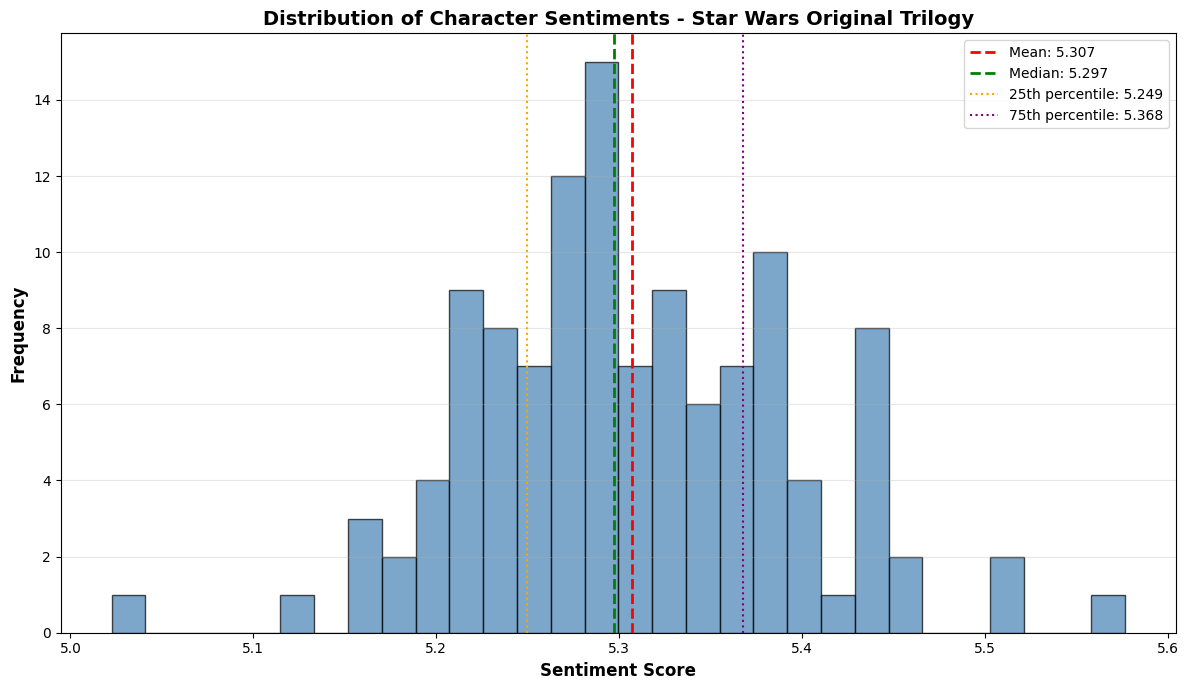


Character Sentiment Statistics:
  Total characters analyzed: 119
  Mean: 5.307
  Median: 5.297
  Std Dev: 0.087
  Min: 5.023
  Max: 5.577


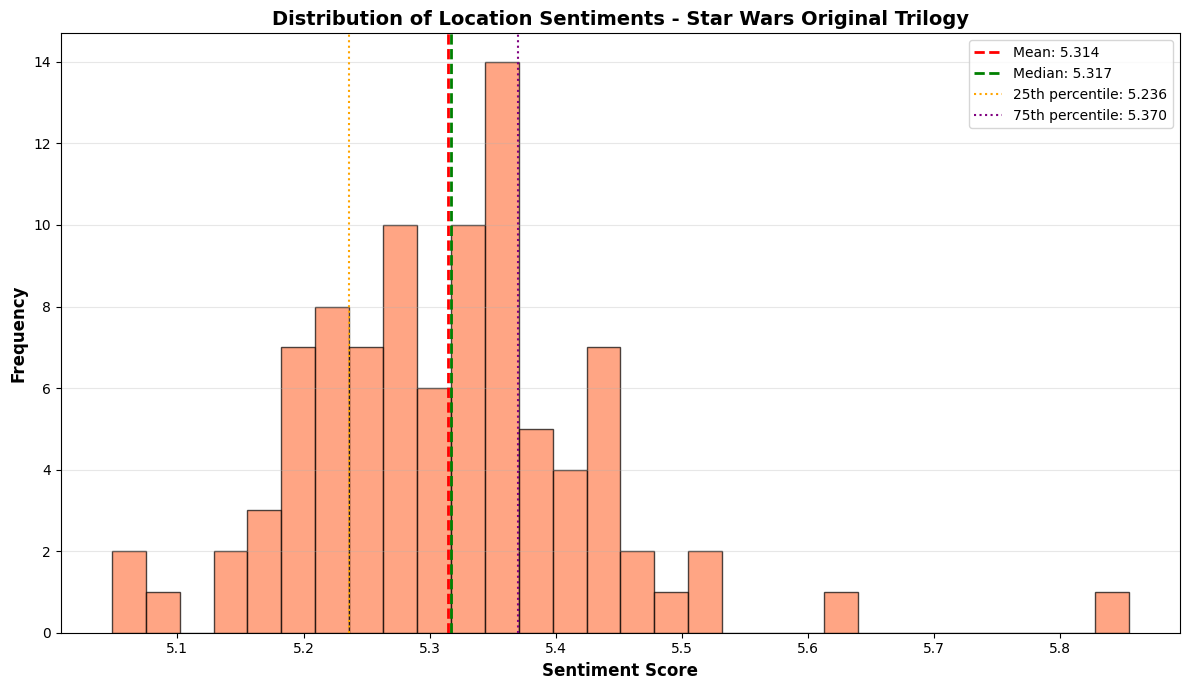


Location Sentiment Statistics:
  Total locations analyzed: 93
  Mean: 5.314
  Median: 5.317
  Std Dev: 0.116
  Min: 5.048
  Max: 5.855


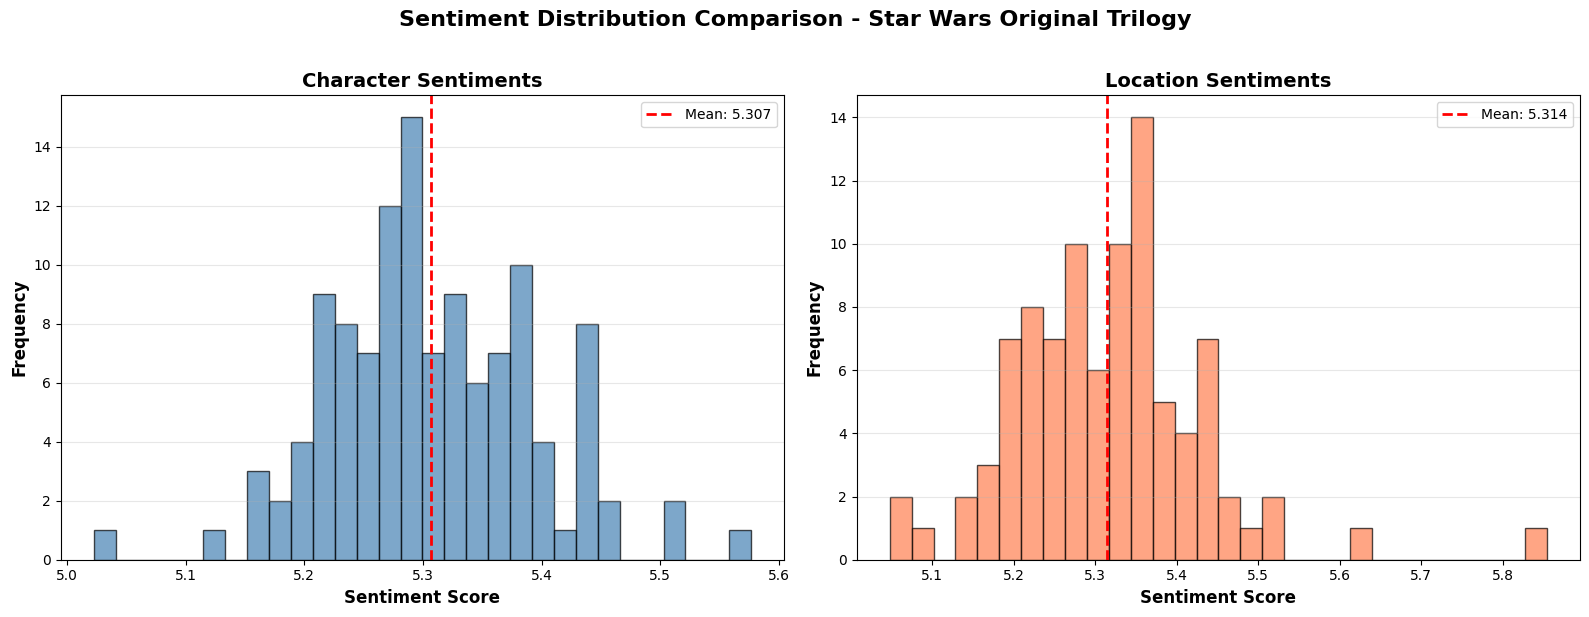

In [64]:
import numpy as np
import matplotlib.pyplot as plt

figures_dir = './figures'
# Extract character sentiments (excluding None values)
character_sentiments = [
    data["sentiment"] for data in character_connections_dict.values() 
    if data["sentiment"] is not None
]

# Extract location sentiments (excluding None values)
location_sentiments = [
    data["sentiment"] for data in location_characters_dict.values() 
    if data["sentiment"] is not None
]

# Plot Character Sentiment Distribution
if character_sentiments:
    mean_sentiment = round(np.mean(character_sentiments), 4)
    median_sentiment = round(np.median(character_sentiments), 4)
    p25_sentiment = round(np.percentile(character_sentiments, 25), 4)
    p75_sentiment = round(np.percentile(character_sentiments, 75), 4)
    
    # Create figure and plot
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Histogram
    ax.hist(character_sentiments, bins=30, color="steelblue", edgecolor="black", alpha=0.7)
    
    # Add vertical lines for statistics
    ax.axvline(mean_sentiment, color="red", linestyle="--", linewidth=2, 
               label=f"Mean: {mean_sentiment:.3f}")
    ax.axvline(median_sentiment, color="green", linestyle="--", linewidth=2, 
               label=f"Median: {median_sentiment:.3f}")
    ax.axvline(p25_sentiment, color="orange", linestyle=":", linewidth=1.5, 
               label=f"25th percentile: {p25_sentiment:.3f}")
    ax.axvline(p75_sentiment, color="purple", linestyle=":", linewidth=1.5,
               label=f"75th percentile: {p75_sentiment:.3f}")
    
    # Labels and title
    ax.set_xlabel("Sentiment Score", fontsize=12, fontweight="bold")
    ax.set_ylabel("Frequency", fontsize=12, fontweight="bold")
    ax.set_title("Distribution of Character Sentiments - Star Wars Original Trilogy", 
                 fontsize=14, fontweight="bold")
    ax.legend(fontsize=10, loc="upper right")
    ax.grid(axis="y", alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(figures_dir + "/character_sentiment_distribution.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nCharacter Sentiment Statistics:")
    print(f"  Total characters analyzed: {len(character_sentiments)}")
    print(f"  Mean: {mean_sentiment:.3f}")
    print(f"  Median: {median_sentiment:.3f}")
    print(f"  Std Dev: {np.std(character_sentiments):.3f}")
    print(f"  Min: {np.min(character_sentiments):.3f}")
    print(f"  Max: {np.max(character_sentiments):.3f}")

# Plot Location Sentiment Distribution
if location_sentiments:
    mean_sentiment = round(np.mean(location_sentiments), 4)
    median_sentiment = round(np.median(location_sentiments), 4)
    p25_sentiment = round(np.percentile(location_sentiments, 25), 4)
    p75_sentiment = round(np.percentile(location_sentiments, 75), 4)
    
    # Create figure and plot
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Histogram
    ax.hist(location_sentiments, bins=30, color="coral", edgecolor="black", alpha=0.7)
    
    # Add vertical lines for statistics
    ax.axvline(mean_sentiment, color="red", linestyle="--", linewidth=2, 
               label=f"Mean: {mean_sentiment:.3f}")
    ax.axvline(median_sentiment, color="green", linestyle="--", linewidth=2, 
               label=f"Median: {median_sentiment:.3f}")
    ax.axvline(p25_sentiment, color="orange", linestyle=":", linewidth=1.5, 
               label=f"25th percentile: {p25_sentiment:.3f}")
    ax.axvline(p75_sentiment, color="purple", linestyle=":", linewidth=1.5,
               label=f"75th percentile: {p75_sentiment:.3f}")
    
    # Labels and title
    ax.set_xlabel("Sentiment Score", fontsize=12, fontweight="bold")
    ax.set_ylabel("Frequency", fontsize=12, fontweight="bold")
    ax.set_title("Distribution of Location Sentiments - Star Wars Original Trilogy", 
                 fontsize=14, fontweight="bold")
    ax.legend(fontsize=10, loc="upper right")
    ax.grid(axis="y", alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(figures_dir + "/location_sentiment_distribution.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nLocation Sentiment Statistics:")
    print(f"  Total locations analyzed: {len(location_sentiments)}")
    print(f"  Mean: {mean_sentiment:.3f}")
    print(f"  Median: {median_sentiment:.3f}")
    print(f"  Std Dev: {np.std(location_sentiments):.3f}")
    print(f"  Min: {np.min(location_sentiments):.3f}")
    print(f"  Max: {np.max(location_sentiments):.3f}")

# Optional: Side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Character sentiments
if character_sentiments:
    axes[0].hist(character_sentiments, bins=30, color="steelblue", edgecolor="black", alpha=0.7)
    axes[0].axvline(np.mean(character_sentiments), color="red", linestyle="--", linewidth=2, 
                    label=f"Mean: {np.mean(character_sentiments):.3f}")
    axes[0].set_xlabel("Sentiment Score", fontsize=12, fontweight="bold")
    axes[0].set_ylabel("Frequency", fontsize=12, fontweight="bold")
    axes[0].set_title("Character Sentiments", fontsize=14, fontweight="bold")
    axes[0].legend(fontsize=10)
    axes[0].grid(axis="y", alpha=0.3)

# Location sentiments
if location_sentiments:
    axes[1].hist(location_sentiments, bins=30, color="coral", edgecolor="black", alpha=0.7)
    axes[1].axvline(np.mean(location_sentiments), color="red", linestyle="--", linewidth=2, 
                    label=f"Mean: {np.mean(location_sentiments):.3f}")
    axes[1].set_xlabel("Sentiment Score", fontsize=12, fontweight="bold")
    axes[1].set_ylabel("Frequency", fontsize=12, fontweight="bold")
    axes[1].set_title("Location Sentiments", fontsize=14, fontweight="bold")
    axes[1].legend(fontsize=10)
    axes[1].grid(axis="y", alpha=0.3)

plt.suptitle("Sentiment Distribution Comparison - Star Wars Original Trilogy", 
             fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.savefig(figures_dir + "/sentiment_comparison.png", dpi=300, bbox_inches='tight')
plt.show()